# 🧠 Laboratory 2 — Training a Neural Network  
## Machine Learning Course (A.A. 2025–2026)  
### Danilo Croce  

In this lab we will train our **first neural network** 🎉  

We will use:  
- **MNIST dataset** — images of handwritten digits (0–9)  
- **PyTorch** — a deep learning framework  

The goal is **not** to build a state-of-the-art model,  
but to **understand the key steps** of training:  

`Dataset → Model → Training Loop → Evaluation`

## What does it mean to "train a model"?

Don’t worry if you don’t get all the details now — this is your **first lab**!  
What matters is understanding the **big picture**:

- We start with **data** (images of digits).  
- Our goal is to learn a **predictive function**:  

      y = f(x)

where:  
- \(x\) = an input (a representation of an image)  
- \(y\) = the output class (which digit it is)  
- \(f\) = the model (here: a neural network, but the principle is the same for all ML models)  

---

### Training in simple words
- At the beginning, the network is **“stupid”** — its parameters are random and predictions are meaningless.  
- During **training**:  
  1. We apply the function ```f(x)``` to some data → predictions.  
  2. We compare predictions with the true labels → **loss**.  
  3. We adjust the parameters in proportion to this loss (using here **backpropagation**).  

---

### Why batches?
- We will understand it... but for now:
  - We don’t show all the data at once, nor only one example at a time.  
  - Instead, we use **batches of data** — this is efficient and helps learning.  
  - Over many passes through the training set (called **epochs**), the model improves.  

---

At the end of training, we obtain a model that we can:  
- **Apply** to new unseen data  
- **Evaluate** to check how well it generalizes

In [ ]:
%matplotlib inline

import torch
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

We can check whether we have GPUs available:

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

## Loading the Dataset

The **MNIST dataset** contains 70,000 grayscale images of handwritten digits.  
Each image is **28x28 pixels**, and the task is to classify it into one of 10 classes (0–9).  

In PyTorch:  
- Images and labels are represented as **tensors** (multidimensional arrays).  
- We will use `torchvision.datasets` to automatically download and load the dataset.  

👉 Think of this as preparing our **training examples** and **ground truth labels**.

## MNIST data set

Next we'll load the MNIST handwritten digits data set.  First time we may have to download the data, which can take a while.

#### Altenative: Fashion-MNIST

Alternatively, MNIST can be replaced with Fashion-MNIST, which can be used as drop-in replacement for MNIST.   Fashion-MNIST contains images of 10 fashion categories:

Label|Description|Label|Description
--- | --- |--- | ---
0|T-shirt/top|5|Sandal
1|Trouser|6|Shirt
2|Pullover|7|Sneaker
3|Dress|8|Bag
4|Coat|9|Ankle boot


In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

Let's take a closer look. Here are the first 20 training digits

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

View an Image in More Detail¶

In [ ]:
img = np.squeeze(images[9])

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## From a Simple Network to a Deeper One

In this lab we will train our **first neural networks**.  
We will start very simple, and then make the model a bit more complex:

- **Step 1:** Train a network with **one hidden layer**  
  - This is the simplest type of Multi-Layer Perceptron (MLP).  
  - Good to understand the training pipeline.  

- **Step 2:** Train a network with **two hidden layers**  
  - Slightly more powerful, able to capture more complex patterns.  
  - The training process is the same — only the architecture changes.  

👉 The goal is **not** to reach perfect accuracy,  
but to **see how model complexity can affect learning**.

## "Linear" model

### Initialization

Let's begin with a simple linear model.  We need to define a `Model` that implement.  Then we add a `Dense` layer that has 28*28=784 input nodes (one for each pixel in the input image) and 10 output nodes. The `Linear` layer connects each input to each output with some weight parameter.
This is the softmax function:
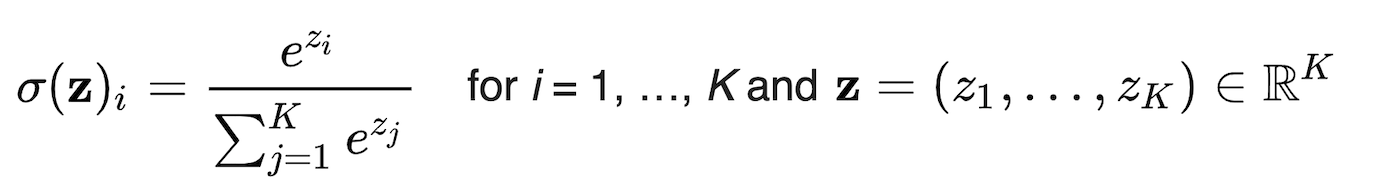



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28 * 28, 10)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # we can apply dropout
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = self.fc(x)

        return x

# initialize the NN
model = Net()
print(model)

**Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)**

It's recommended that you use cross-entropy loss for classification. Here the softmax is not required as the `CrossEntropyLoss`is expected to be directly applied to logits. (If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer and then calculates the log loss.)

In [ ]:
## Specify loss and optimization functions

# specify loss function. NOTE: it contains the softmax so it is not needed to
# implement it in the network definition
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### Learning

Now we are ready to train our first model.  An *epoch* means one pass through the whole training data.

The steps for training/learning from a batch of data are described in the comments below:

*   Clear the gradients of all optimized variables
*   Forward pass: compute predicted outputs by passing inputs to the model
*   Calculate the loss
*   Backward pass: compute gradient of the loss with respect to model parameters
*   Perform a single optimization step (parameter update)
*   Update average training loss

The following loop trains for 10 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.

In [ ]:
# number of epochs to train the model
n_epochs = 20  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)

    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        train_loss
        ))

## Inference

Finally, we test our best model on previously unseen test data and evaluate it's performanc

`model.eval()` will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

*Here* are the first 20 test digits the linear model classified, with the incorrect classification are in red

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

## Multi-layer perceptron (MLP) network

### Activation functions

Let's start by plotting some common activation functions for neural networks. `'relu'` stands for rectified linear unit, $y=\max(0,x)$, a very simple non-linearity we will be using in our MLP network below.

In [ ]:
x = np.arange(-4,4,.01)
plt.figure()
plt.plot(x, np.maximum(x,0), label='relu')
plt.plot(x, 1/(1+np.exp(-x)), label='sigmoid')
plt.plot(x, np.tanh(x), label='tanh')
plt.axis([-4, 4, -1.1, 1.5])
plt.title('Activation functions')
plt.legend(loc='best');

### Initialization

Let's now create a more complex MLP model that has multiple layers, non-linear activation functions, and dropout layers.  `Dropout()` randomly sets a fraction of inputs to zero during training, which is one approach to regularization and can sometimes help to prevent overfitting.

There are two options below, a simple and a bit more complex model.  Select either one.

The output of the last layer needs to be a softmaxed 10-dimensional vector to match the groundtruth (`Y_train`).

Finally, we again `compile()` the model, this time using [*Adam*](https://keras.io/optimizers/#adam) as the optimizer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 20)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(20, 20)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(20, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

        self.relu = F.relu

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = self.fc3(self.dropout(self.relu(self.fc2(self.relu(self.fc1(x))))))
        return x

# initialize the NN
model2 = MLP()
print(model2)

### Learning

*IMPORTANT*: since the models is changes, the Optimized must be updated.

In [ ]:
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01)

In [ ]:
# number of epochs to train the model
n_epochs = 35  # suggest training between 20-50 epochs

model2.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer2.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model2(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer2.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)

    # print training statistics
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        train_loss
        ))

### Inference

Accuracy for test data.  The model should be somewhat better than the linear model.

In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model2.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model2(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

We can again take a closer look on the results, using the `show_failures()` function defined earlier.

Here are the first 10 test digits the MLP classified to a wrong class:

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

## ⚠️ Important Considerations

In this lab we trained and tested a simple neural network.  
It worked better when we added one hidden layer — great! 🎉  

But… did we do everything correctly?  

- We split the dataset into **training** and **test**.  
- However, when adjusting model choices (e.g. number of layers, neurons, learning rate…),  
  we **should not** look at the test set each time.  
- Why?  
  - Because then we are **tuning hyperparameters using the test set**.  
  - This means we are indirectly "peeking" at data that should stay unseen until the very end.  
  - As a result, our test accuracy may look great… but it may be just a **lucky coincidence** and not generalize to new data.  

---

### What’s missing here?
- A **validation (development) set**:  
  - Split from the training set.  
  - Used for **tuning hyperparameters** (like number of layers, neurons, etc.).  
  - The **test set must remain untouched** until the final evaluation.  

👉 Always remember:  
- **Train** → fit the model.  
- **Validation** → tune hyperparameters.  
- **Test** → final, unbiased evaluation.  